In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import IPython.display
import numpy as np
from pycaret.time_series import TSForecastingExperiment
import os
import plotly.express as px
from pmdarima import auto_arima
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

In [7]:
df = pd.read_csv(r'../data/01_raw/incidents.csv')
df_2 = pd.read_csv(r'../data/01_raw/incidents-07-07-2023.csv')
df = df[['date', 'etat_failed']]
df_2 = df_2[['date', 'etat_failed']]

In [8]:
df_2 = df_2.head(7)
df_2.tail(20)

,date,etat_failed
0,2023-07-07,58
1,2023-07-06,79
2,2023-07-05,61
3,2023-07-04,71
4,2023-07-03,223
5,2023-07-02,63
6,2023-07-01,55


In [9]:
df = pd.concat([df, df_2], axis=0)
df = df[['date', 'etat_failed']]

In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:
df.set_index('date', inplace=True)

In [12]:
df = df.asfreq('D')

In [13]:
df

,etat_failed
date,
2021-11-18,88.0
2021-11-19,5.0
2021-11-20,NaN
2021-11-21,NaN
2021-11-22,12.0
...,...
2023-07-03,223.0
2023-07-04,71.0
2023-07-05,61.0


In [14]:
df = df[['etat_failed']]
df['etat_failed'] = df['etat_failed'].fillna(0)
df

,etat_failed
date,
2021-11-18,88.0
2021-11-19,5.0
2021-11-20,0.0
2021-11-21,0.0
2021-11-22,12.0
...,...
2023-07-03,223.0
2023-07-04,71.0
2023-07-05,61.0


In [15]:
df['weekday'] = df.index.weekday
df

,etat_failed,weekday
date,,
2021-11-18,88.0,3
2021-11-19,5.0,4
2021-11-20,0.0,5
2021-11-21,0.0,6
2021-11-22,12.0,0
...,...,...
2023-07-03,223.0,0
2023-07-04,71.0,1
2023-07-05,61.0,2


In [16]:
#df_mon = df[df['weekday'] == 0]

In [17]:
df_check = df[['etat_failed']]

<Axes: xlabel='date'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

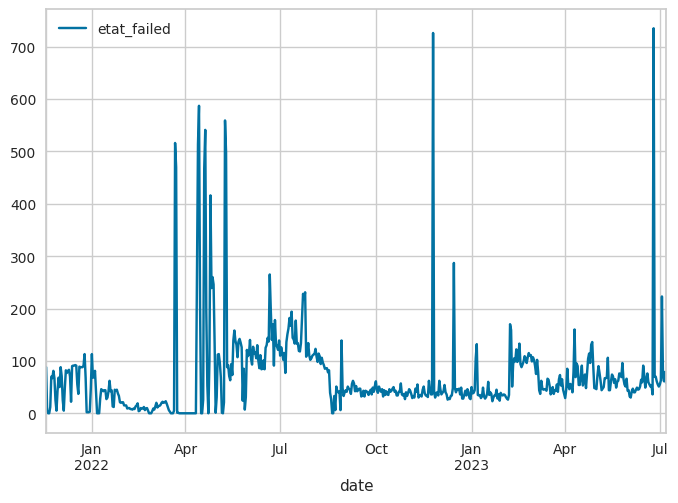

In [18]:
df_check.plot()

## Stationary check

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

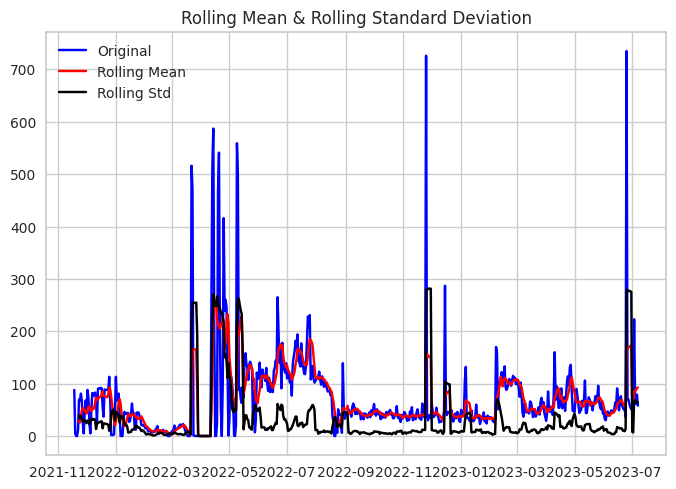

In [19]:
rolling_mean = df_check.rolling(window = 6).mean()
rolling_std = df_check.rolling(window = 6).std()
plt.plot(df_check, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [20]:
### Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

In [21]:
test_result=adfuller(df['etat_failed'])

In [22]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [23]:
adfuller_test(df['etat_failed'])

ADF Test Statistic : -3.075721515817719
p-value : 0.028402861159104984
#Lags Used : 19
Number of Observations Used : 577
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


## Differencing

In [24]:
#df['etat (first difference)'] = df['etat_failed'] - df['etat_failed'].shift(1)

In [25]:
df['etat_failed'].shift(1)

date
2021-11-18      NaN
2021-11-19     88.0
2021-11-20      5.0
2021-11-21      0.0
2021-11-22      0.0
              ...  
2023-07-03     63.0
2023-07-04    223.0
2023-07-05     71.0
2023-07-06     61.0
2023-07-07     79.0
Freq: D, Name: etat_failed, Length: 597, dtype: float64

In [26]:
df['Seasonal First Difference']=df['etat_failed']-df['etat_failed'].shift(7)

In [27]:
df.head(14)

,etat_failed,weekday,Seasonal First Difference
date,,,
2021-11-18,88.0,3,NaN
2021-11-19,5.0,4,NaN
2021-11-20,0.0,5,NaN
2021-11-21,0.0,6,NaN
2021-11-22,12.0,0,NaN
2021-11-23,70.0,1,NaN
2021-11-24,67.0,2,NaN
2021-11-25,81.0,3,-7.0
2021-11-26,67.0,4,62.0


In [28]:
df.tail()

,etat_failed,weekday,Seasonal First Difference
date,,,
2023-07-03,223.0,0,153.0
2023-07-04,71.0,1,1.0
2023-07-05,61.0,2,0.0
2023-07-06,79.0,3,24.0
2023-07-07,58.0,4,7.0


In [29]:
## Again test dickey fuller test
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -9.035490334182786
p-value : 5.303312298499976e-15
#Lags Used : 15
Number of Observations Used : 574
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='date'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

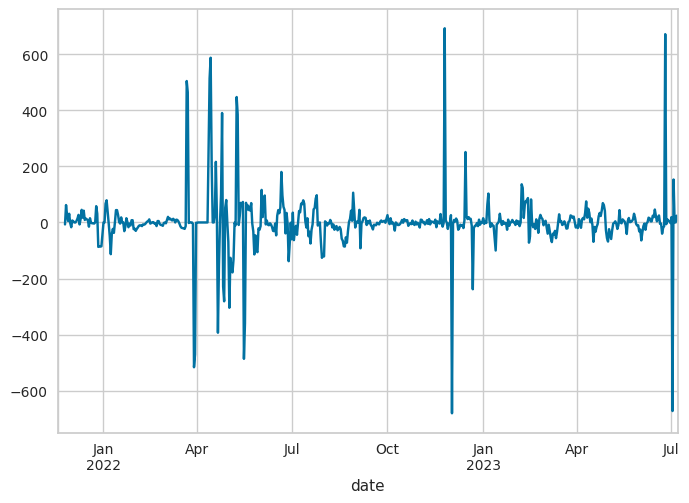

In [30]:
df['Seasonal First Difference'].plot()

In [31]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

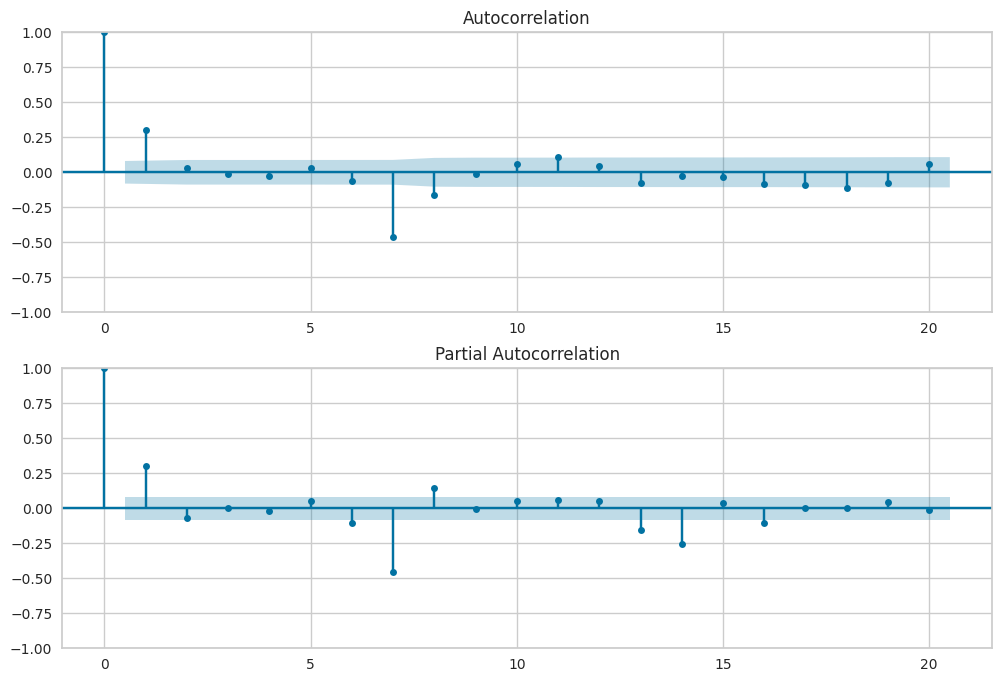

In [32]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal First Difference'].iloc[7:],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal First Difference'].iloc[7:],lags=20,ax=ax2)


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

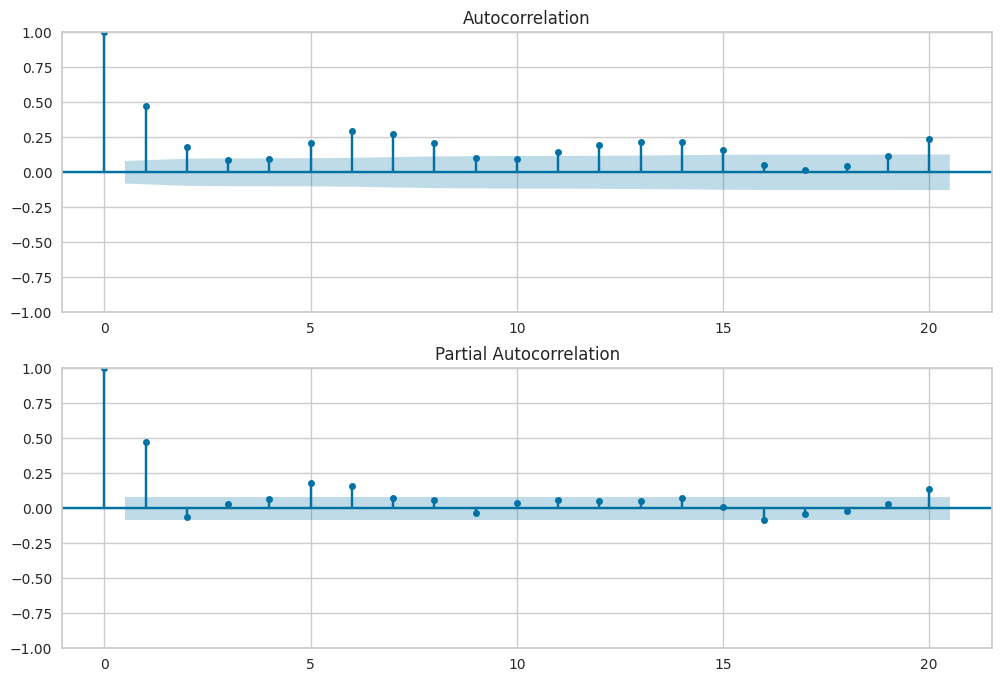

In [33]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['etat_failed'].iloc[7:],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['etat_failed'].iloc[7:],lags=20,ax=ax2)

In [34]:
from statsmodels.tsa.arima.model import ARIMA

In [35]:
model=ARIMA(df['etat_failed'],order=(1,1,1))
model_fit=model.fit()

In [36]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            etat_failed   No. Observations:                  597
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3387.114
Date:                Mon, 10 Jul 2023   AIC                           6780.228
Time:                        14:27:43   BIC                           6793.399
Sample:                    11-18-2021   HQIC                          6785.357
                         - 07-07-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3730      0.018     21.303      0.000       0.339       0.407
ma.L1         -0.9511      0.011    -83.496      0.000      -0.973      -0.929
sigma2      5042.0396     62.708     80.405      0.000    4919.134    5164.945
===================================================================================
Ljung-Box (L1) (Q):                   1.59   Jarque-Bera (JB):             45974.17
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             5.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='date'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

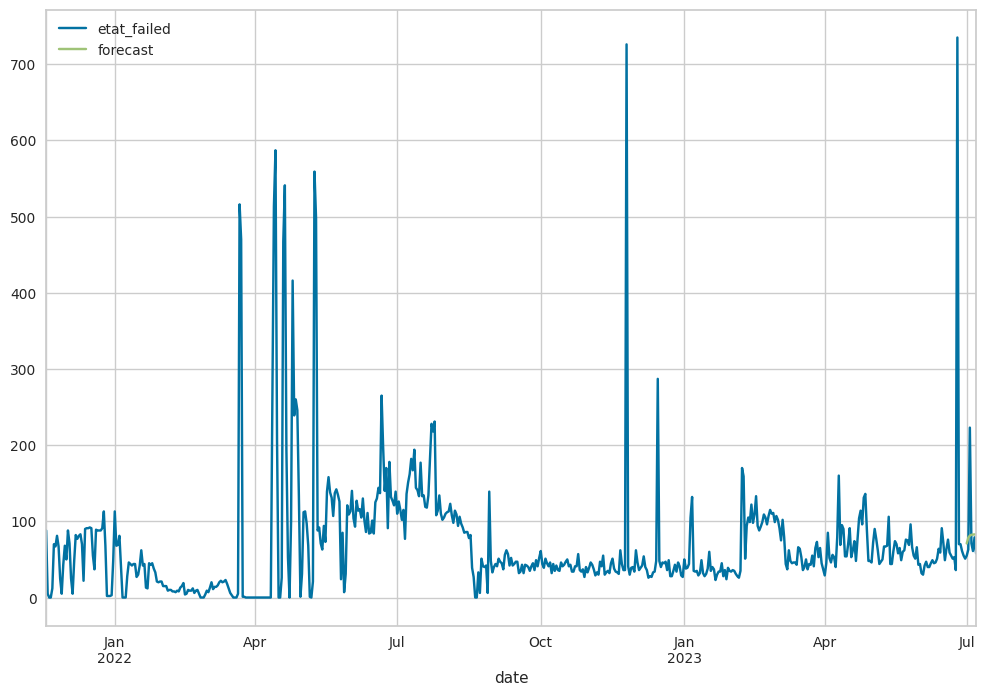

In [37]:
end = len(df)
start= end - 7
df['forecast']=model_fit.predict(start=start,end=end,dynamic=True)
df[['etat_failed','forecast']].plot(figsize=(12,8))

In [38]:
import statsmodels.api as sm

In [39]:
model=sm.tsa.statespace.SARIMAX(df['etat_failed'],order=(1, 1, 1),seasonal_order=(1,1,1,7))
results=model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77637D+00    |proj g|=  6.23859D-02

At iterate    5    f=  5.74130D+00    |proj g|=  1.56486D-02

At iterate   10    f=  5.64968D+00    |proj g|=  5.56318D-02

At iterate   15    f=  5.64211D+00    |proj g|=  4.04096D-04
  ys=-1.456E-03  -gs= 1.143E-03 BFGS update SKIPPED

At iterate   20    f=  5.63601D+00    |proj g|=  5.41468D-02

At iterate   25    f=  5.62731D+00    |proj g|=  1.56324D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Proj

In [40]:
len(df)

597

<Axes: xlabel='date'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

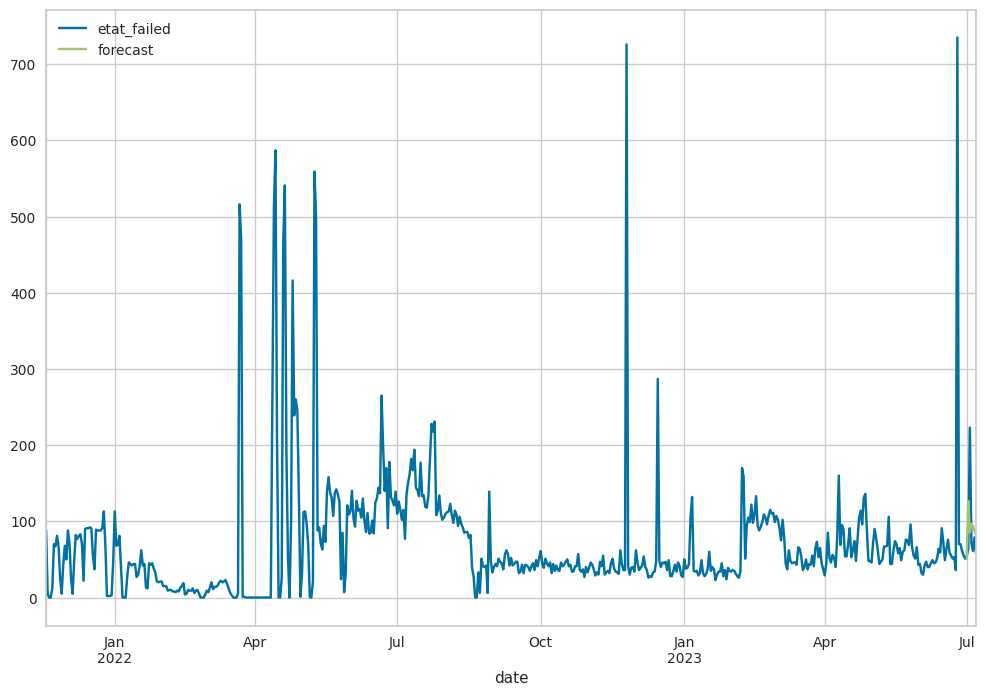

In [41]:
df['forecast']=results.predict(start=start,end=end,dynamic=True)
df[['etat_failed','forecast']].plot(figsize=(12,8))

<Axes: xlabel='date'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

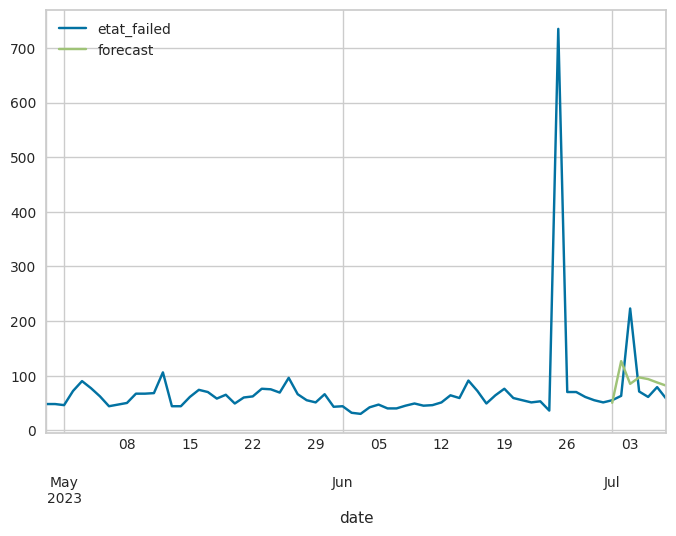

In [42]:
df[['etat_failed', 'forecast']].tail(70).plot()

In [43]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(days=x)for x in range(0,8)]

In [44]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [45]:
future_datest_df

,etat_failed,weekday,Seasonal First Difference,forecast
2023-07-08,NaN,NaN,NaN,NaN
2023-07-09,NaN,NaN,NaN,NaN
2023-07-10,NaN,NaN,NaN,NaN
2023-07-11,NaN,NaN,NaN,NaN
2023-07-12,NaN,NaN,NaN,NaN
2023-07-13,NaN,NaN,NaN,NaN
2023-07-14,NaN,NaN,NaN,NaN


In [46]:
future_df=pd.concat([df,future_datest_df])

<Axes: >

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

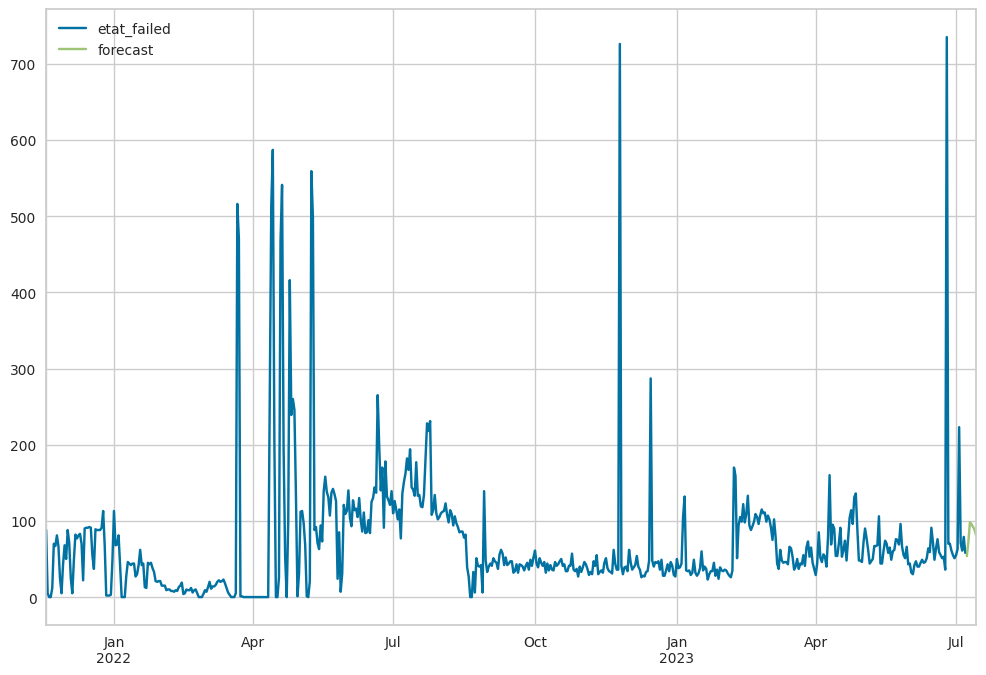

In [47]:
future_df['forecast'] = results.predict(start = (end), end=(end+7), dynamic= True)  
future_df[['etat_failed', 'forecast']].plot(figsize=(12, 8)) 

<Axes: >

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

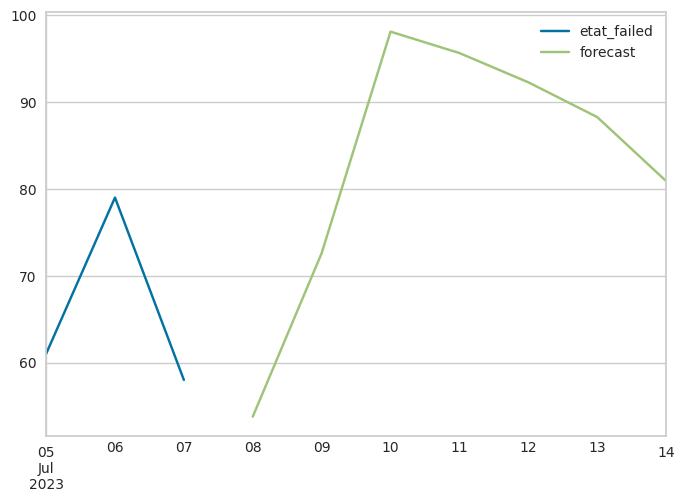

In [48]:
future_df[['etat_failed', 'forecast']].tail(10).plot()

In [49]:
df.tail(10)

,etat_failed,weekday,Seasonal First Difference,forecast
date,,,,
2023-06-28,61.0,2,6.0,NaN
2023-06-29,55.0,3,4.0,NaN
2023-06-30,51.0,4,-2.0,NaN
2023-07-01,55.0,5,19.0,50.317194
2023-07-02,63.0,6,-672.0,126.601918
2023-07-03,223.0,0,153.0,84.979733
2023-07-04,71.0,1,1.0,96.806663
2023-07-05,61.0,2,0.0,93.691059
2023-07-06,79.0,3,24.0,87.522172


In [50]:
df['AE'] = abs(df['etat_failed'] - df['forecast'])

In [51]:
df['AE'].tail(7).mean()

42.431764331311435

In [52]:
df['etat_failed'].mode()

0    0.0
Name: etat_failed, dtype: float64

In [53]:
future_df.tail()

,etat_failed,weekday,Seasonal First Difference,forecast
2023-07-10,NaN,NaN,NaN,98.104795
2023-07-11,NaN,NaN,NaN,95.637624
2023-07-12,NaN,NaN,NaN,92.269757
2023-07-13,NaN,NaN,NaN,88.266207
2023-07-14,NaN,NaN,NaN,80.899419
